In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import string
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

### Reading Raw Data 

In [2]:
with open('data/ytrain.txt', 'r') as f:
    labels = f.read().splitlines()
    labels = np.array([int(label) for label in labels])

with open("data/xtrain_obfuscated.txt", 'r') as f:
    lines = f.read().splitlines()

In [3]:
print('Number of labels: ', len(labels))
print('Labels:', np.unique(labels))
print('NUmber of classes: ', len(np.unique(labels)))

Number of labels:  32513
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
NUmber of classes:  12


In [4]:
print('Number of training samples: ', len(lines))
print('line 0: ')
print(lines[0])
print('It\'s label: ', labels[0])

Number of training samples:  32513
line 0: 
satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhlemvtwamuluhiwiwenuhlrvimvqvkruhulenamuluhqgqvtwvimviwuhtwamuluhulqvkrenamcitwuhvipmpmqvuhskiwkrpmdfuhlrvimvskvikrpmqvuhskmvgzenleuhqvmvamuluhulenamuluhqvletwtwvipmpmgzleenamuhtwamuluhtwletwdfuhiwkrxeleentwxeuhpmqvuhtwiwmvamdfuhpkeztwamuluhvimvuhqvtwmkpmpmlelruhgztwtwskuhtwlrkrpmlruhpmuluhqvenuhtwyplepmxeuhenuhamypkrqvuhamulmvdfuhqvskentwamletwlrlrpmiwuhtwamul
It's label:  7


Let's have a look at some lines

In [5]:
print('line 15: ')
print(lines[15])

line 15: 
raxexepmuhleenxeuhpmqvuhqgulmvuhletwxetwlegzuhskiwkrpmamqvuhletwskentwleuhtwamuluhxemvuhqglepmvtsatvletwskvikrpmdfuhraleqjuhqvendfuhleentwviuhpmxyuhuhraulvitwezmvulvitwqvuhxepmuhskmvpmmktwskuhsaiwulyptwxeletwgzuhvienezuhletwamulpmvienuhqvskleendfpmuluhgzmvamqvvipmmvuleniwtwleuhiwenkrulmvlemvgzqvuhulenamuluhamypenpmlegzgzenuhvienypuhulvitwezmvulvitwqvuhxepmuhskmvpmmktwskuhsaiwulyptwxeletwgzuhvienez


In [6]:
print('line 25: ')
print(lines[25])

line 25: 
saengzuhpmuluhsktwmvleuluhvitwleskiwmvamypuhtwamuluhpkqvezmveniwypuhqvulmvuhulletwqvqvenuhpmuluhvienlrtwtvuhtwkrlrmvulenxeuhqgsatvbhskvienbhsadfuhqvmvamuhvimvuhqvtwyptwmvgzuhlekrpmxeuhlepmuhtwtwleamuluhskvienuhtwiwskvienypuhtwiwpmamdfuhenuhskenamuhezpmguuhulenamuluhdftwviucuhtwamxyuhravimvenlrenuhsktwmvskuhtwgzpmamuhletwamuhskvienuhqgskpmpmulqvletwskvikruhsaucyptwdfuhrasktwsktwtwviuhulpmviuhtwletwdfuhqvsklepmokuhoaamypkrez


### Some info about data

#### Labels distribution

In [7]:
# to plot a nice picture it has to take array of numbers form 0 to num_classes-1 and each 
# number in this range has to occur at least once
def plot_labels_dist(labels):
    left_of_first_bin = labels.min() - 1/4
    right_of_last_bin = labels.max() + 1/2

    plt.hist(labels, np.arange(left_of_first_bin, right_of_last_bin, 1/2))
    plt.grid()
    plt.xticks(np.arange(0, max(labels)+1, 1))
    plt.xlabel('class')
    plt.ylabel('number of elements')
    plt.title('Labels distribution')
    plt.show()

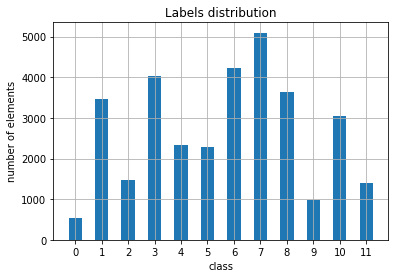

In [8]:
plot_labels_dist(labels)

We can see that there are sighificantly few examples for class 0 and also few for 2, 9 11

#### distribution of lines length

In [9]:
lines_length = np.array([len(line) for line in lines])

In [10]:
def plot_length_dist(lines_length):
    fig = plt.figure()
    
    ax1 = plt.subplot('121')
    ax1.set_title('default range')
    ax1.hist(lines_length, bins=100)
    ax1.grid()
    ax1.set_xlabel('Line\'s length')
    ax1.set_ylabel('Number of lines')
    
    ax2 = plt.subplot('122')
    ax2.set_title('range zoom')
    ax2.hist(lines_length, bins=100)
    ax2.grid()
    ax2.set_xlim((320,450))
    ax2.set_xlabel('Line\'s length')
    ax2.set_ylabel('Number of lines')
    
    fig.subplots_adjust(top=1, bottom=0, left=0, right=2.2, hspace=0.2, wspace=0.3)
    
    plt.show()

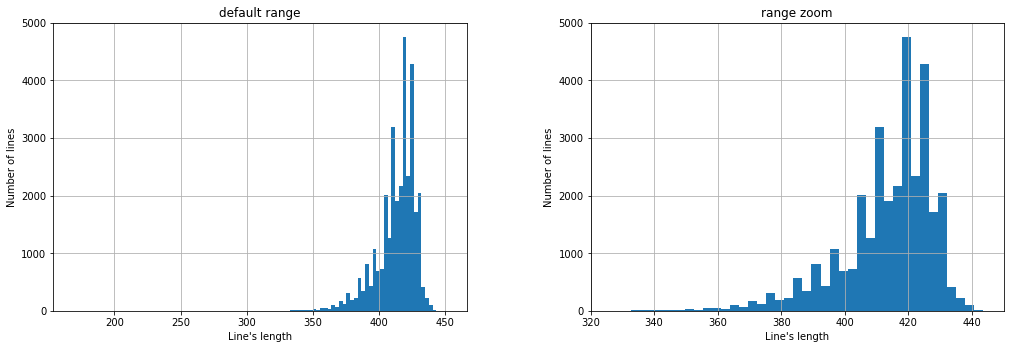

In [11]:
plot_length_dist(lines_length)

#### Length distribution per class

In [12]:
def plot_length_dist_per_class(lines_length, labels, num_classes=12):
    for label in range(num_classes):
        print('class:', label)
        plot_length_dist(lines_length[labels==label])

class: 0


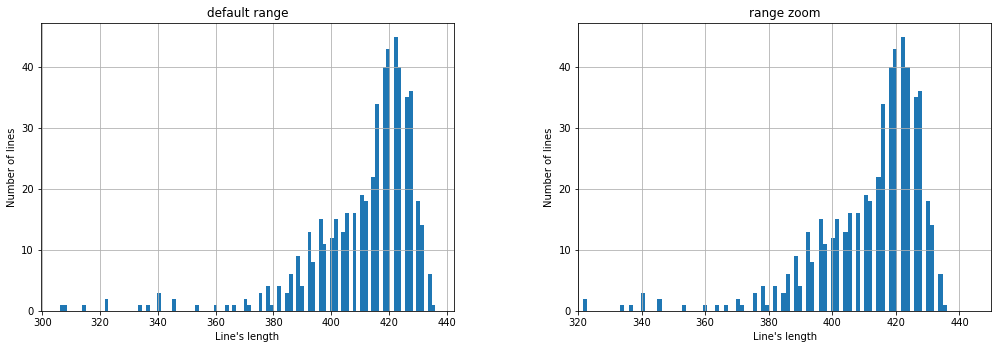

class: 1


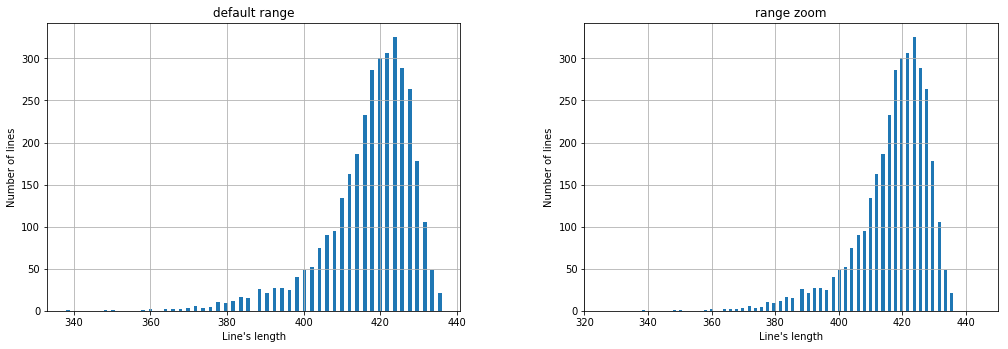

class: 2


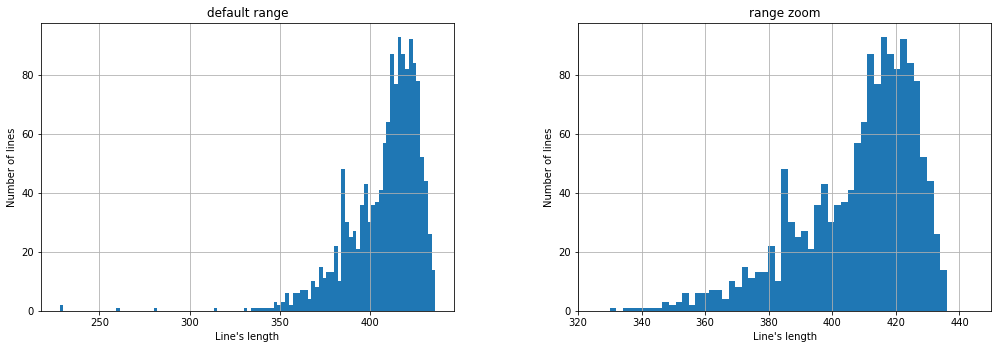

class: 3


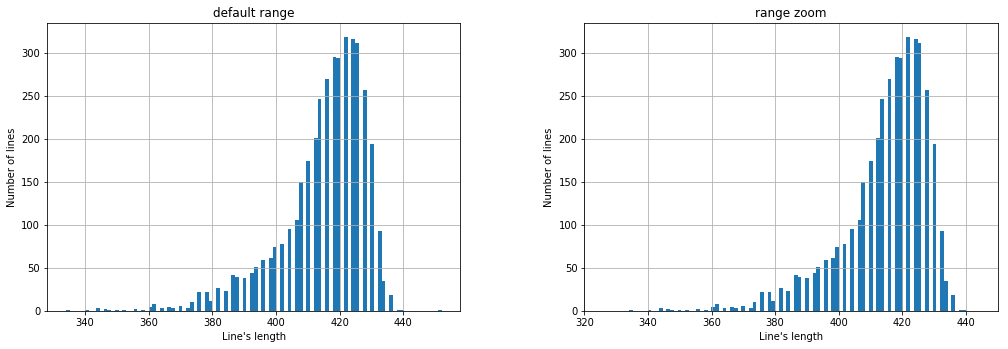

class: 4


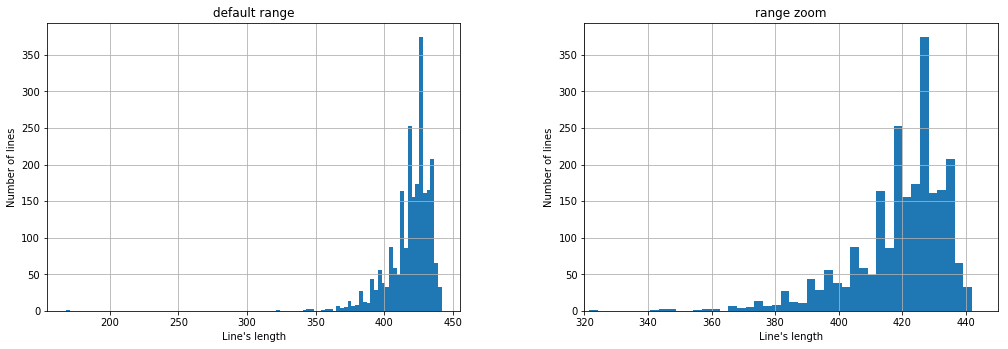

class: 5


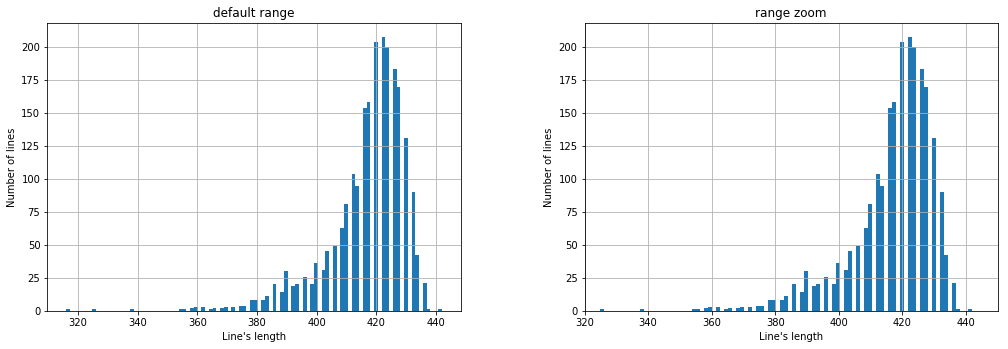

class: 6


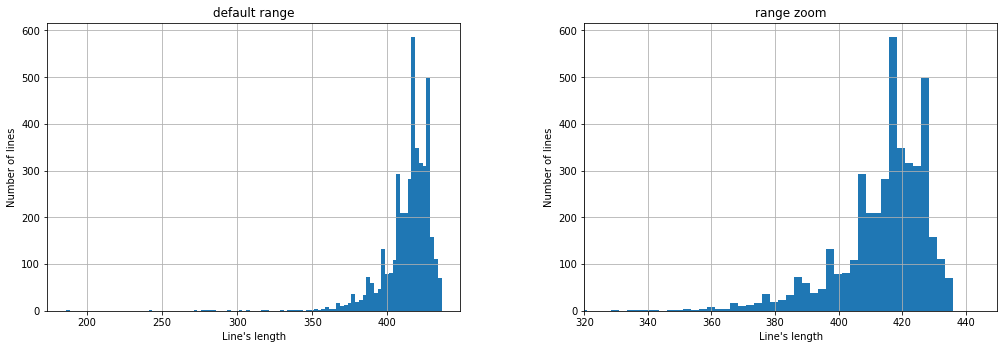

class: 7


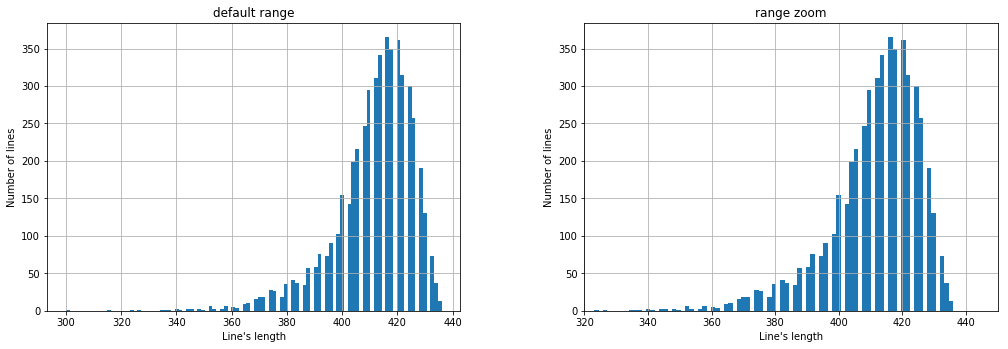

class: 8


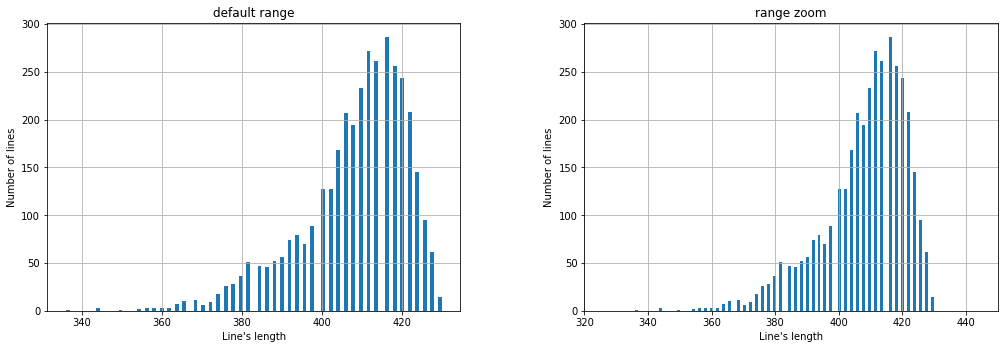

class: 9


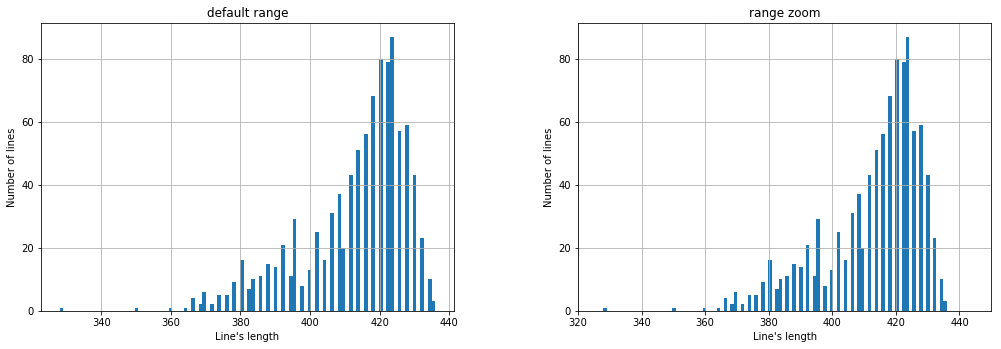

class: 10


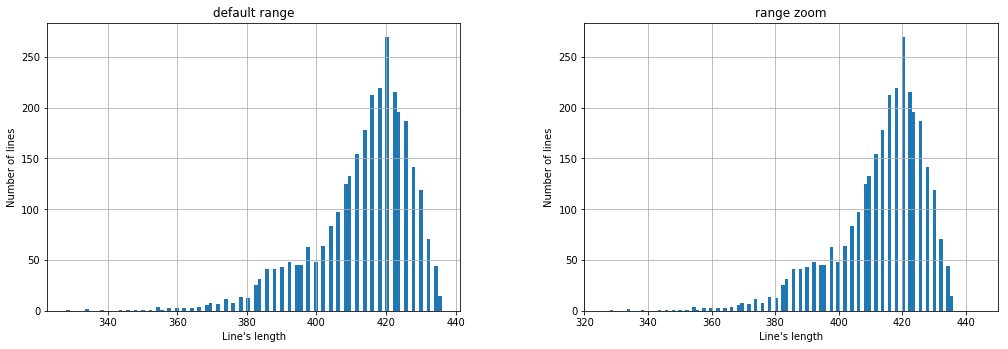

class: 11


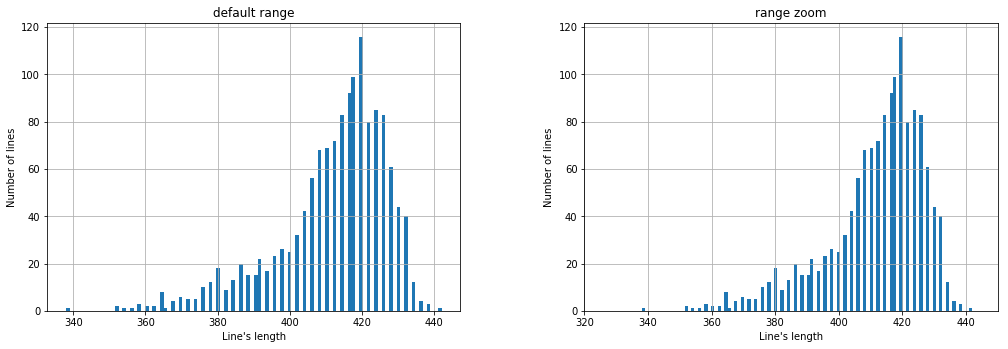

In [13]:
plot_length_dist_per_class(lines_length, labels)

#### statistics

In [14]:
df = pd.DataFrame({'string':lines, 'label':labels, 'len':lines_length})
df.head()

,label,len,string
0,7,406,satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhle...
1,3,386,twmkiwpmqvtwleuhsaiwsktwmvlelekramuhqvkruhtwsk...
2,8,418,vidfpmskuhvilepmuluhtwtvuhulsovienamqvuhskiwmv...
3,3,426,raskleenkrlruhtwulenleengztwqvuhenuhsatvuhsktw...
4,4,416,dfenqvuhtwamqvuhqgtwiwtvenuluhqvijletwamulenxe...


In [15]:
print('Mean line length:', df['len'].mean())
print('Median line length:', df['len'].median())

Mean line length: 413.389351952
Median line length: 416.0


In [18]:
grouped = df.groupby(['label'])

In [19]:
print('Mean line length for each class')
print(grouped['len'].mean())

Mean line length for each class
label
0     411.756906
1     417.347788
2     407.574439
3     414.810341
4     419.327343
5     416.992554
6     413.569333
7     411.261919
8     408.265823
9     412.910204
10    413.150721
11    411.846591
Name: len, dtype: float64


In [20]:
print('Mean line length for each class')
print(grouped['len'].median())

Mean line length for each class
label
0     418
1     420
2     412
3     418
4     424
5     420
6     418
7     414
8     412
9     418
10    416
11    416
Name: len, dtype: int64


In [21]:
print('Number of labels in each class:')
print(grouped['label'].count())

Number of labels in each class:
label
0      543
1     3459
2     1471
3     4023
4     2337
5     2283
6     4226
7     5097
8     3634
9      980
10    3052
11    1408
Name: label, dtype: int64


In [22]:
print('Labels ratio:')
print(grouped['label'].count() / df['label'].size)

Labels ratio:
label
0     0.016701
1     0.106388
2     0.045243
3     0.123735
4     0.071879
5     0.070218
6     0.129979
7     0.156768
8     0.111771
9     0.030142
10    0.093870
11    0.043306
Name: label, dtype: float64


#### It seems like each string containts only lowercase letters from the latin alphabet. Let's check this assumption:

In [23]:
letters = list(string.ascii_lowercase)
print(letters)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [24]:
for i in tqdm(range(len(lines))):
    for c in lines[i]:
        if c not in letters:
            print('There is a character {} in the line {} that doesn\'t belong to the alphabet'.format(c, i))

100%|██████████| 32513/32513 [00:03<00:00, 8537.51it/s]


Assumption is correct

### Simple fast stupid baseline

I just conut number of occurrences of each letter into a string

In [25]:
X = np.zeros([len(lines), len(letters)])
X.shape 

(32513, 26)

In [26]:
lines_encoded = []
for line in tqdm(lines):
    d = dict()
    for c in letters:
        d[c] = 0
    for c in line:
        d[c] += 1
    lines_encoded.append(d)

100%|██████████| 32513/32513 [00:01<00:00, 19312.94it/s]


In [27]:
lines_encoded[0]

{'a': 17,
 'b': 0,
 'c': 2,
 'd': 4,
 'e': 25,
 'f': 4,
 'g': 5,
 'h': 34,
 'i': 16,
 'j': 0,
 'k': 16,
 'l': 34,
 'm': 41,
 'n': 10,
 'o': 0,
 'p': 17,
 'q': 15,
 'r': 16,
 's': 7,
 't': 23,
 'u': 50,
 'v': 30,
 'w': 30,
 'x': 3,
 'y': 2,
 'z': 5}

In [28]:
for i, d in enumerate(lines_encoded):
    vector = [d[key] for key in d]
    X[i,:] = vector

In [29]:
X[0,:]

array([ 16.,   7.,   5.,   0.,   2.,  30.,  16.,   5.,   2.,  10.,  17.,
        34.,  16.,  25.,  23.,  41.,   0.,   4.,   4.,  50.,   0.,  17.,
        34.,   3.,  30.,  15.])

In [30]:
y = labels
y.shape

(32513,)

training dataset X_train and y_train is created. Now I split it to train val test datasets

#### splitting data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)

In [32]:
X_train.shape

(29261, 26)

In [33]:
X_train.shape

(29261, 26)

In [34]:
df_y_train = pd.DataFrame({'label':y_train})
print('Labels ration in splitted train set')
print(df_y_train.groupby(['label'])['label'].count() / df_y_train.size)

Labels ration in splitted train set
label
0     0.016712
1     0.106387
2     0.045248
3     0.123748
4     0.071870
5     0.070230
6     0.129968
7     0.156762
8     0.111753
9     0.030143
10    0.093879
11    0.043300
Name: label, dtype: float64


In [35]:
df_y_test = pd.DataFrame({'label':y_test})
print('Labels ration in splitted test set')
print(df_y_test.groupby(['label'])['label'].count() / df_y_test.size)

Labels ration in splitted test set
label
0     0.016605
1     0.106396
2     0.045203
3     0.123616
4     0.071956
5     0.070111
6     0.130074
7     0.156827
8     0.111931
9     0.030135
10    0.093788
11    0.043358
Name: label, dtype: float64


#### linear svm

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [39]:
model = SVC(kernel='linear', C=1)

In [40]:
%%time
scores = cross_val_score(model, X_train, y_train, cv=4, n_jobs=4)

CPU times: user 484 ms, sys: 160 ms, total: 644 ms
Wall time: 9min


In [41]:
print(scores)
print('Cross-val score:', np.mean(scores))

[ 0.38506454  0.40347372  0.39498384  0.39356626]
Cross-val score: 0.394272089386


In [42]:
%%time
model.fit(X_train, y_train)

CPU times: user 7min 43s, sys: 2.35 s, total: 7min 46s
Wall time: 7min 46s


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
%%time
y_pred = model.predict(X_train)
print('Train accuracy:', accuracy_score(y_true=y_train, y_pred=y_pred))

Train accuracy: 0.399961553249
CPU times: user 20.9 s, sys: 0 ns, total: 20.9 s
Wall time: 20.9 s


In [46]:
%%time
y_pred = model.predict(X_test)
print('Test accuracy:', accuracy_score(y_true=y_test, y_pred=y_pred))

Test accuracy: 0.397970167615
CPU times: user 5.25 s, sys: 0 ns, total: 5.25 s
Wall time: 5.25 s


#### poly kernel svm

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=1, stratify=y)

In [111]:
model = SVC(kernel='poly', degree=2, C=1)

In [112]:
%%time
model.fit(X_train, y_train)

CPU times: user 31.1 s, sys: 4 ms, total: 31.1 s
Wall time: 31.1 s


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [114]:
%%time
y_pred = model.predict(X_train)
print('Train accuracy:', accuracy_score(y_true=y_train, y_pred=y_pred))

Train accuracy: 0.989538461538
CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 108 ms


In [115]:
%%time
y_pred = model.predict(X_test)
print('Test accuracy:', accuracy_score(y_true=y_test, y_pred=y_pred))

Test accuracy: 0.277356902357
CPU times: user 1.82 s, sys: 0 ns, total: 1.82 s
Wall time: 1.82 s


#### rbf svm

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [117]:
model = SVC(kernel='rbf', gamma=0.1, C=1)

In [118]:
%%time
model.fit(X_train, y_train)

CPU times: user 3min 5s, sys: 1.81 s, total: 3min 7s
Wall time: 3min 7s


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [119]:
%%time
y_pred = model.predict(X_train)
print('Train accuracy:', accuracy_score(y_true=y_train, y_pred=y_pred))

Train accuracy: 1.0
CPU times: user 53.7 s, sys: 36 ms, total: 53.7 s
Wall time: 53.8 s


In [120]:
%%time
y_pred = model.predict(X_test)
print('Test accuracy:', accuracy_score(y_true=y_test, y_pred=y_pred))

Test accuracy: 0.156696909119
CPU times: user 11.1 s, sys: 0 ns, total: 11.1 s
Wall time: 11.1 s
